In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
tier2_map = {
    "Neurons": "Neurons",
    "T cells": "T cells",
    "B cells": "B cells",
    "APCs": "APC/DC",
    "Dendritic cells": "APC/DC",

    "Macrophages": "Macrophages/Myeloid",
    "Myeloid cells": "Macrophages/Myeloid",
    "Efflux Mic_Mac": "Macrophages/Myeloid",
    "Foamy Mic_Mac": "Macrophages/Myeloid",
    "Activate Mic_Mac 1": "Macrophages/Myeloid",
    "Activated Mic_Mac 2": "Macrophages/Myeloid",

    "Microglia": "Microglia",
    "Proliferating microglia": "Microglia",

    "Astrocytes": "Astrocytes",
    "Astrocyte": "Astrocytes",
    "DA astrocytes": "Astrocytes",
    "Mic_AST": "Mic_AST",  # mixed microglia–astro signature → keep under DA astrocytes

    "Oligodendrocytes": "Oligodendrocytes",
    "DA oligodendrocytes": "Oligodendrocytes",
    "DA Oligodendrocytes": "Oligodendrocytes",
    "Newly formed oligodendrocytes": "Newly formed oligodendrocytes",
    "OPCs": "OPCs",
    "Schwann cells": "Schwann cells",

    "Endothelial cells": "Endothelial",
    "Vascular cells": "Endothelial",

    "Fibroblasts": "Fibroblasts",
    "Stromal cells": "Stromal",

    "Ependymal cells": "Ependymal",
    "unclear": "Unclassified",
}
adata.obs['cell_type_reduced'] = adata.obs['cell_type'].map(tier2_map).fillna("Unclassified")

# compute log2fc dataframe

In [5]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

# map your obs['model'] labels to the MODELS keys
MODEL_LABEL_TO_FAMILY = {"Chronic": "MOG", "RR": "PLP"}  # adjust if needed

def _get_counts(adata, layer="raw"):
    return adata.layers[layer] if layer in adata.layers else adata.X

def _pseudobulk_sum(X, idx):
    sub = X[idx, :]
    if sp.issparse(sub): 
        return np.asarray(sub.sum(axis=0)).ravel()
    return sub.sum(axis=0)

def _cpm(mat, axis=1):
    mat = mat.astype(float)
    lib = mat.sum(axis=axis, keepdims=True)
    lib[lib == 0] = 1.0
    return (mat / lib) * 1e6

def make_log2fc_vs_baseline(
    adata,
    MODELS,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",
    model_col="model",
    case="EAE",
    control="CONTROL",
    layer="raw",
):
    # --- prep obs ---
    obs = adata.obs.copy()
    if model_col not in obs:
        raise KeyError(f"obs['{model_col}'] missing.")
    if condition_col not in obs:
        raise KeyError(f"obs['{condition_col}'] missing.")

    # normalize strings
    obs["_celltype"]  = obs[celltype_col].astype(str).str.strip()
    obs["_course"]    = obs[course_col].astype(str).str.strip()
    obs["_condition"] = obs[condition_col].astype(str).str.strip().str.upper()
    obs["_model_lbl"] = obs[model_col].astype(str).str.strip()

    # map model label -> family ("MOG" or "PLP")
    obs["_family"] = obs["_model_lbl"].map(MODEL_LABEL_TO_FAMILY)
    if obs["_family"].isna().any():
        unknown = sorted(obs.loc[obs["_family"].isna(), "_model_lbl"].unique())
        raise ValueError(f"Unmapped model labels in obs['{model_col}']: {unknown}. "
                         f"Edit MODEL_LABEL_TO_FAMILY.")

    X = _get_counts(adata, layer=layer)
    if sp.issparse(X): 
        X = X.tocsr()
    genes = np.array(adata.var_names)

    # index of rows by (celltype, family, course, condition)
    idx_df = pd.DataFrame({
        "row": np.arange(adata.n_obs),
        "celltype":  obs["_celltype"].values,
        "family":    obs["_family"].values,
        "course":    obs["_course"].values,
        "condition": obs["_condition"].values,
    })

    # build pseudobulks for all groups present
    groups = idx_df.groupby(["celltype","family","course","condition"])["row"].apply(list).reset_index()

    # pseudobulk CPM per group
    ps_counts = np.vstack([_pseudobulk_sum(X, rows) for rows in groups["row"]])
    ps_cpm = _cpm(ps_counts, axis=1)
    ps = pd.DataFrame(ps_cpm, columns=list(genes))
    ps = pd.concat([groups.drop(columns=["row"]), ps], axis=1)

    out_rows = []

    for family, spec in MODELS.items():
        baseline = spec["baseline"]            # e.g., "MOG CFA" or "PLP CFA"
        courses  = spec["courses"]             # ordered list for plotting

        # CONTROL baseline pseudobulk for this family (per celltype)
        ctrl_base = ps.query("family == @family and course == @baseline and condition == @control")
        if ctrl_base.empty:
            # allow slightly different casing in CONTROL
            ctrl_base = ps.query("family == @family and course == @baseline and condition.str.upper() == @control", engine='python')
        if ctrl_base.empty:
            raise ValueError(f"No CONTROL baseline found for family '{family}' at course '{baseline}'.")

        # make lookup: celltype -> baseline CPM vector
        base_lookup = {ct: ctrl_base.loc[ctrl_base["celltype"]==ct, genes].mean(axis=0).to_numpy()
                       for ct in ctrl_base["celltype"].unique()}

        # for each non-baseline course: compute EAE vs CONTROL-baseline log2FC
        eae_df = ps.query("family == @family and condition == @case and course != @baseline")
        if eae_df.empty:
            continue

        for (ct, crs), sub in eae_df.groupby(["celltype","course"]):
            case_vec = sub[genes].mean(axis=0).to_numpy()
            base_vec = base_lookup.get(ct, None)
            if base_vec is None:
                # if no baseline control for this ct, skip
                continue
            l2fc = np.log2((case_vec + 1.0) / (base_vec + 1.0))
            out_rows.append(pd.DataFrame({
                "celltype": ct,
                "model":    "Chronic model" if family=="MOG" else "Relapse-remitting model",
                "course":   crs,
                "gene":     genes,
                "log2fc":   l2fc
            }))

    if not out_rows:
        raise ValueError("No log2FC rows computed. Check MODELS, labels, or availability of baseline CONTROL.")

    log2fc_df = pd.concat(out_rows, ignore_index=True)
    return log2fc_df

In [6]:
MODELS = {'MOG': {'baseline': 'MOG CFA',
  'courses': ['non symptomatic',
   'early onset',
   'chronic peak',
   'chronic long']},
 'PLP': {'baseline': 'PLP CFA',
  'courses': ['onset I',
   'onset II',
   'peak I',
   'monophasic',
   'remitt I',
   'peak II',
   'remitt II',
   'peak III']}}

genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


In [7]:
log2fc_df = make_log2fc_vs_baseline(
    adata,
    MODELS=MODELS,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition_col="condition",
    model_col="model",     # 'Chronic' / 'RR' in your data
    case="EAE",
    control="CONTROL",
    layer="raw"
)


# visualize the log2fc over course

In [8]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np

def plot_models_by_celltypes(log2fc_df, genes, MODELS,
                             celltypes=("Astrocytes","Oligodendrocytes"),
                             model_order=("Chronic model","Relapse-remitting model"),
                             vmax=None, cmap_name="RdBu_r",
                             fig_scale=(3.2, 5.0),  # width per panel, height
                             cbar_pad=0.18):
    """
    Draws 2 panels per cell type (Chronic + RR).
    Adds one centered title above each cell type pair.
    """
    # panels: [(ct, model), (ct, model), ...]
    panels = []
    for ct in celltypes:
        for mdl in model_order:
            panels.append((ct, mdl))

    n = len(panels)
    fig_w = fig_scale[0] * n
    fig_h = fig_scale[1]
    fig, axes = plt.subplots(1, n, figsize=(fig_w, fig_h), constrained_layout=False)

    norm = TwoSlopeNorm(vcenter=0) if vmax is None else TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)

    def course_order_for(model_label):
        fam = "MOG" if "Chronic" in model_label else "PLP"
        return MODELS[fam]["courses"]

    last_im = None
    for ax, (ct, mdl) in zip(axes, panels):
        d = log2fc_df.query("celltype == @ct and model == @mdl")
        if d.empty:
            ax.axis("off")
            continue

        stages = course_order_for(mdl)
        M = d.pivot_table(index="gene", columns="course", values="log2fc", aggfunc="mean")
        M = M.reindex(index=genes, columns=stages).fillna(0.0).values

        last_im = ax.imshow(M, aspect="equal", cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_xticks(np.arange(len(stages)))
        ax.set_xticklabels(stages, rotation=90, fontsize=9)
        ax.set_yticks(np.arange(len(genes)))
        ax.set_yticklabels(genes, fontsize=10, fontstyle="italic")
        ax.set_title(mdl, fontsize=11, pad=4, fontweight="semibold")

        # square gridlines
        ax.set_xticks(np.arange(-0.5, len(stages), 1), minor=True)
        ax.set_yticks(np.arange(-0.5, len(genes), 1), minor=True)
        ax.grid(which="minor", color="black", linewidth=0.6)
        ax.tick_params(which="minor", length=0)

    # ----- center a title above each cell-type pair -----
    # compute midpoints for each consecutive pair of axes
    for i, ct in enumerate(celltypes):
        a0 = axes[2*i].get_position()
        a1 = axes[2*i+1].get_position()
        mid_x = (a0.x0 + a1.x1) / 2.0
        y_top = a0.y1 + 0.1
        fig.text(mid_x, y_top, ct, ha="center", va="bottom",
                 fontsize=16, fontweight="bold")

    # colorbar, pushed outward
    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), fraction=0.025, pad=cbar_pad)
        cbar.set_label("log2FC vs CONTROL baseline", rotation=90)

    # tighten spacing (adjust right to leave room for cbar)
    plt.subplots_adjust(left=0.0001, right=0.82, wspace=0.25, bottom=0.15, top=0.88)
    plt.show()

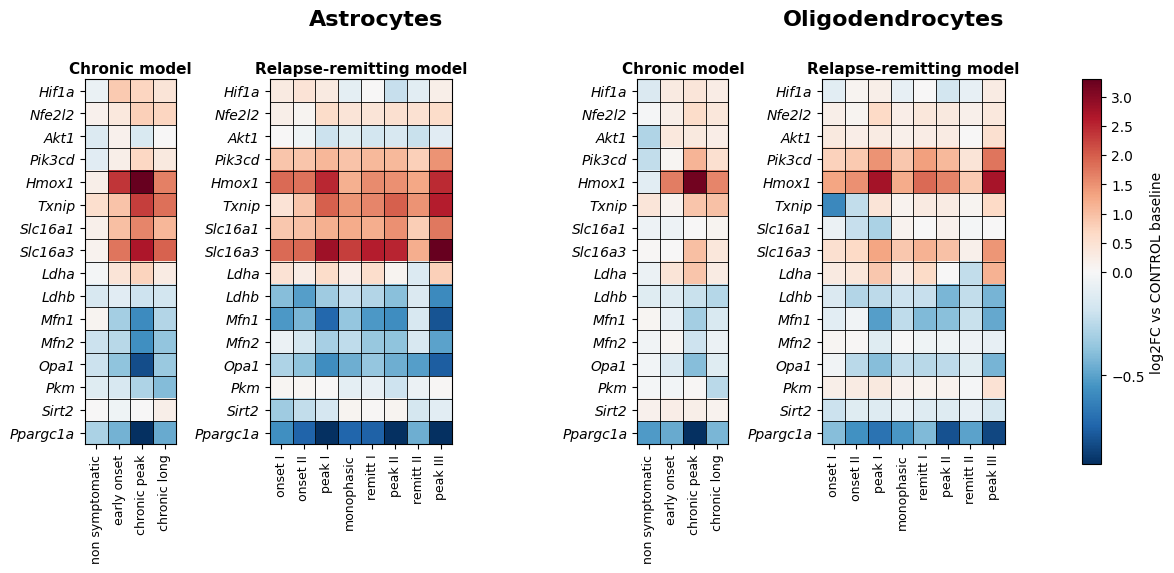

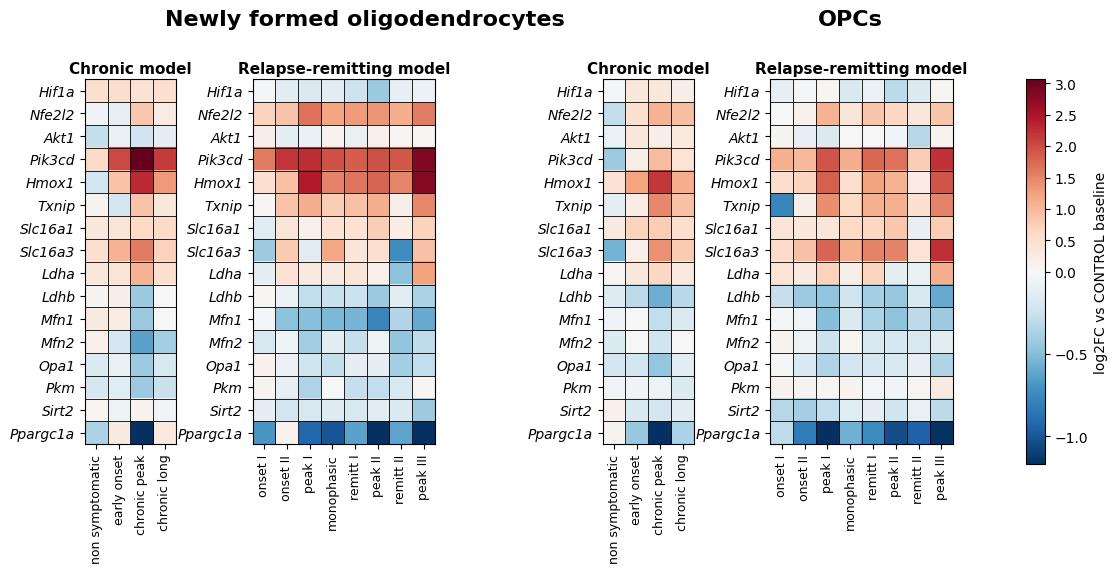

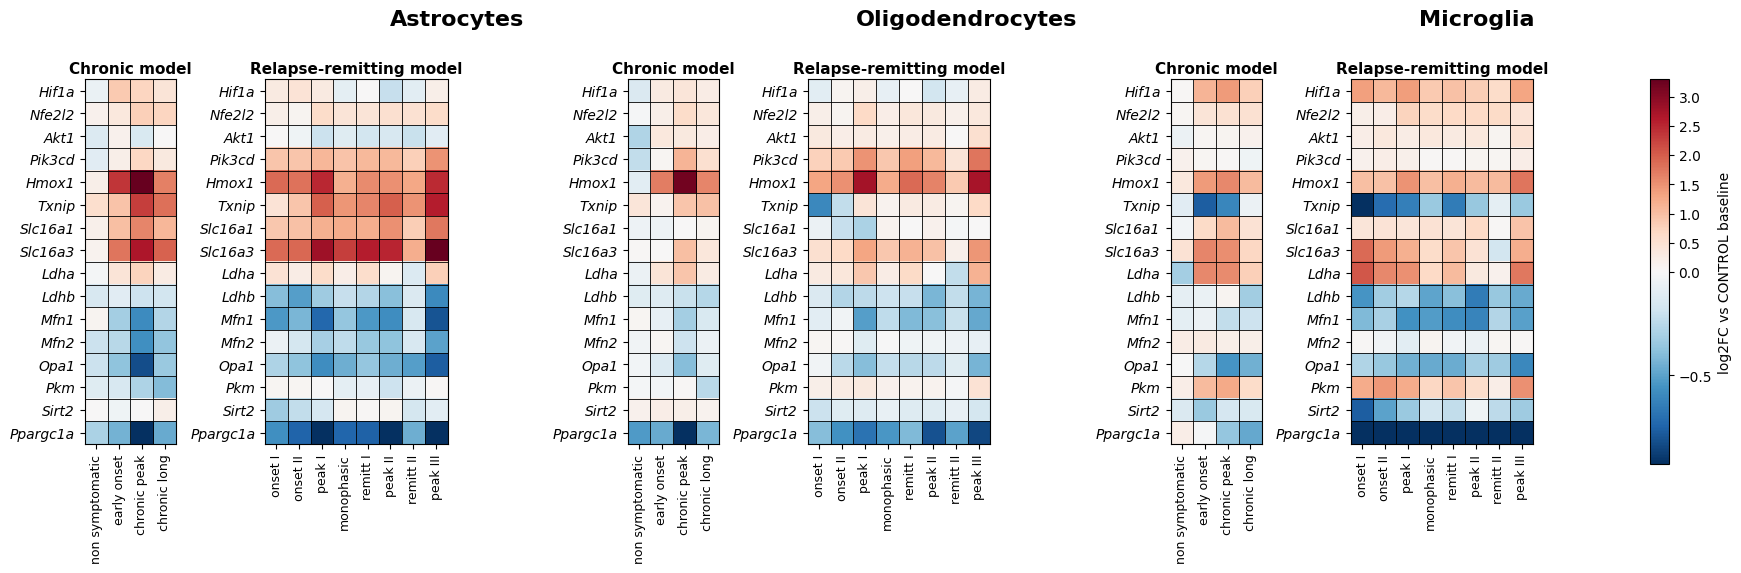

In [9]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]

# Same as before (Astro + Oligo)
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Astrocytes","Oligodendrocytes"))

# Any other types, e.g., Microglia + Endothelial + Neurons
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Newly formed oligodendrocytes","OPCs"),
                         fig_scale=(3.0, 5.0), cbar_pad=0.5)

# If you want a fixed symmetric scale, e.g., ±2
plot_models_by_celltypes(log2fc_df, genes, MODELS,
                         celltypes=("Astrocytes","Oligodendrocytes","Microglia"),
                         cbar_pad=0.001)

In [10]:
import numpy as np, pandas as pd, scipy.sparse as sp, matplotlib.pyplot as plt

def histograms_separate_per_group(
    adata, genes, *,
    celltype_col="cell_type_reduced",
    course_col="course",
    condition="EAE",
    layer="raw",
    celltypes=None, courses=None,
    bins=25, q=0.995, max_cells_per_group=20000,
    figsize_per_ax=(2.6, 2.2)
):
    # --- matrix & indices ---
    X = adata.layers[layer] if (layer in adata.layers) else adata.X
    if sp.issparse(X): X = X.tocsr()
    var_idx = {g:i for i,g in enumerate(adata.var_names)}

    obs = adata.obs
    cts = list(celltypes) if celltypes is not None else list(obs[celltype_col].unique())
    crs = list(courses) if courses is not None else list(obs[course_col].unique())

    # build groups = [(label, row_indices)]
    groups = []
    for ct in cts:
        for cs in crs:
            m = (obs[celltype_col]==ct) & (obs[course_col]==cs)
            if "condition" in obs.columns and condition is not None:
                m &= (obs["condition"].astype(str).str.upper()==str(condition).upper())
            rows = np.flatnonzero(m.values)
            if rows.size == 0: 
                continue
            if rows.size > max_cells_per_group:
                rows = np.random.choice(rows, size=max_cells_per_group, replace=False)
            groups.append((f"{ct}\n{cs}", rows))
    if not groups:
        raise ValueError("No cells matched your filters.")

    # cache per-group submatrix for all requested genes
    gene_cols = [var_idx[g] for g in genes if g in var_idx]
    submats = {lab: (X[rows, :][:, gene_cols].toarray() if sp.issparse(X) else np.asarray(X[rows, :][:, gene_cols]))
               for lab, rows in groups}

    for gi, g in enumerate(genes):
        if g not in var_idx:
            print(f"Skipping {g} (not in var_names)")
            continue

        # robust xmax from all groups for this gene
        samples = np.concatenate([submats[lab][:, gi] for lab, _ in groups])
        xmax = float(np.quantile(samples, q)) if samples.size else 1.0
        if xmax <= 0: xmax = 1.0
        edges = np.linspace(0, xmax, bins+1)
        centers = 0.5*(edges[1:]+edges[:-1])

        n_groups = len(groups)
        ncols = min(6, n_groups)
        nrows = int(np.ceil(n_groups / ncols))
        fw, fh = figsize_per_ax
        fig, axes = plt.subplots(nrows, ncols, figsize=(fw*ncols, fh*nrows), squeeze=False)
        axes = axes.ravel()

        for ax, (lab, _) in zip(axes, groups):
            vals = submats[lab][:, gi]
            h, _ = np.histogram(np.clip(vals, 0, xmax), bins=edges)
            ax.bar(centers, h, width=np.diff(edges), align="center", color="steelblue", alpha=0.8)
            m = vals.mean() if vals.size else np.nan
            if np.isfinite(m):
                ax.axvline(m, ls="--", lw=1, color="crimson", alpha=0.9)
                ax.text(m, ax.get_ylim()[1]*0.9, f"{m:.2f}",
                        color="crimson", fontsize=8, ha="center", va="top", rotation=90)
            ax.set_title(lab, fontsize=9)
            ax.set_xlim(0, xmax); ax.set_ylim(bottom=0)
            ax.set_xlabel("Raw counts", fontsize=8)
            ax.set_ylabel("# cells", fontsize=8)
            ax.grid(alpha=0.2, axis="y")

        # turn off any extra empty axes
        for j in range(len(groups), len(axes)):
            axes[j].axis("off")

        fig.suptitle(g, fontsize=12, fontstyle="italic")
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

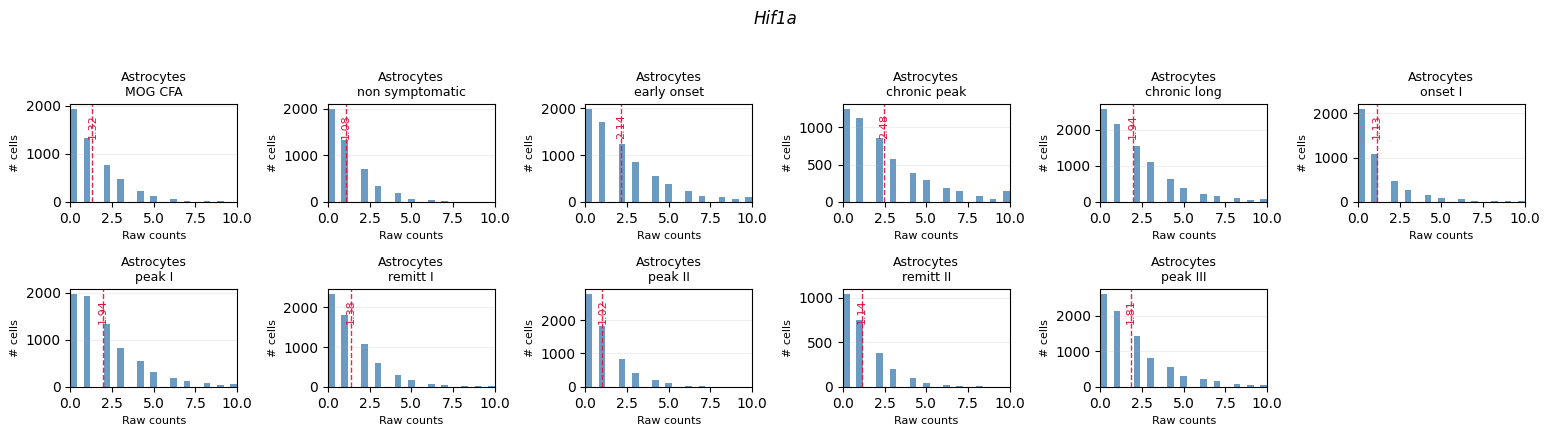

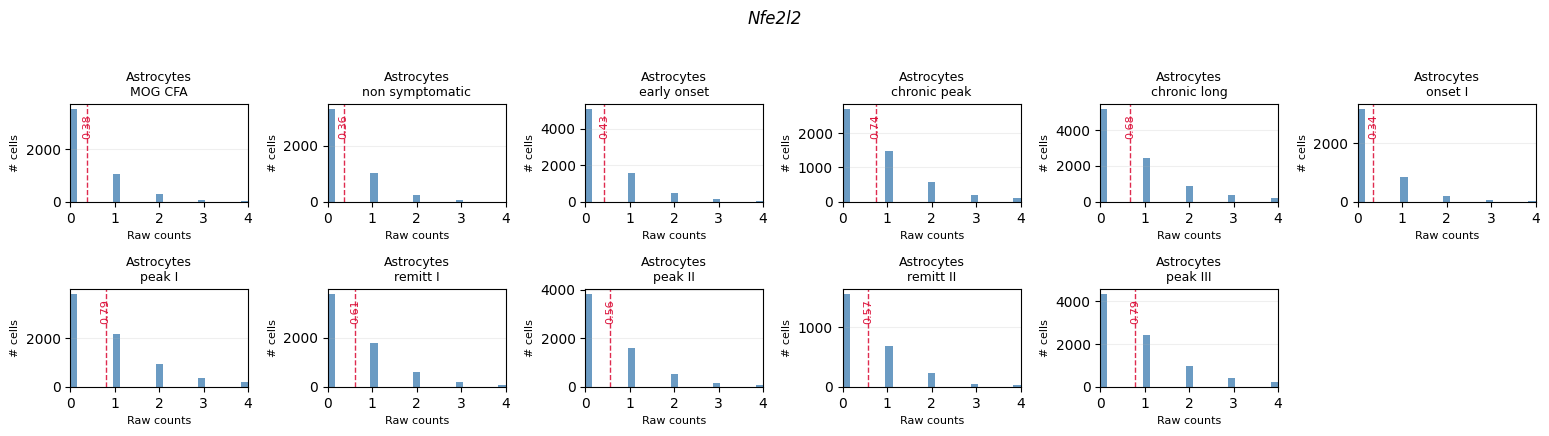

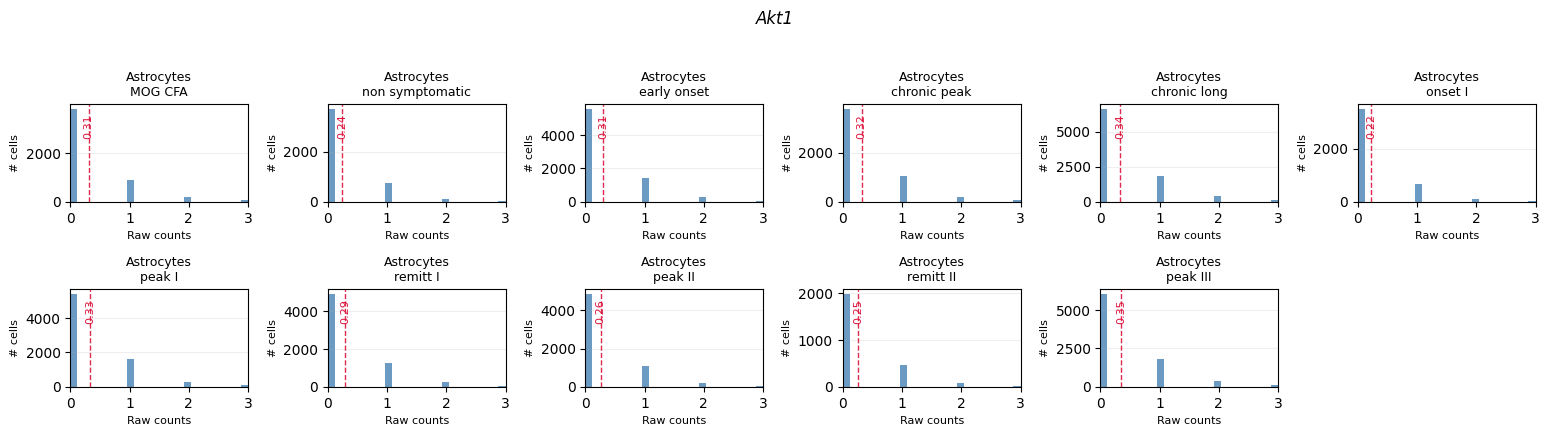

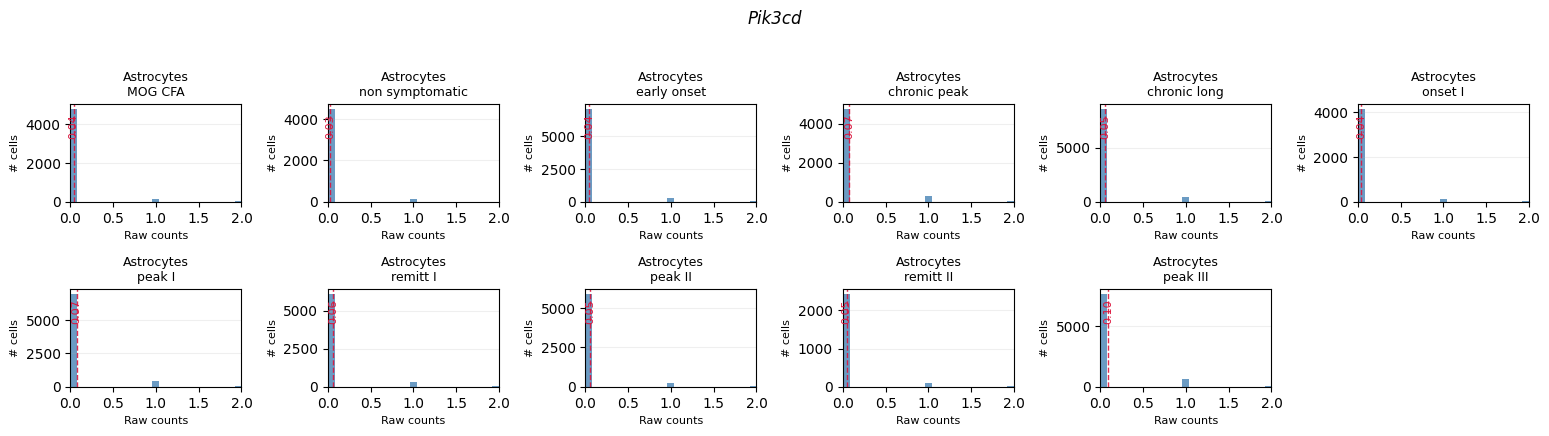

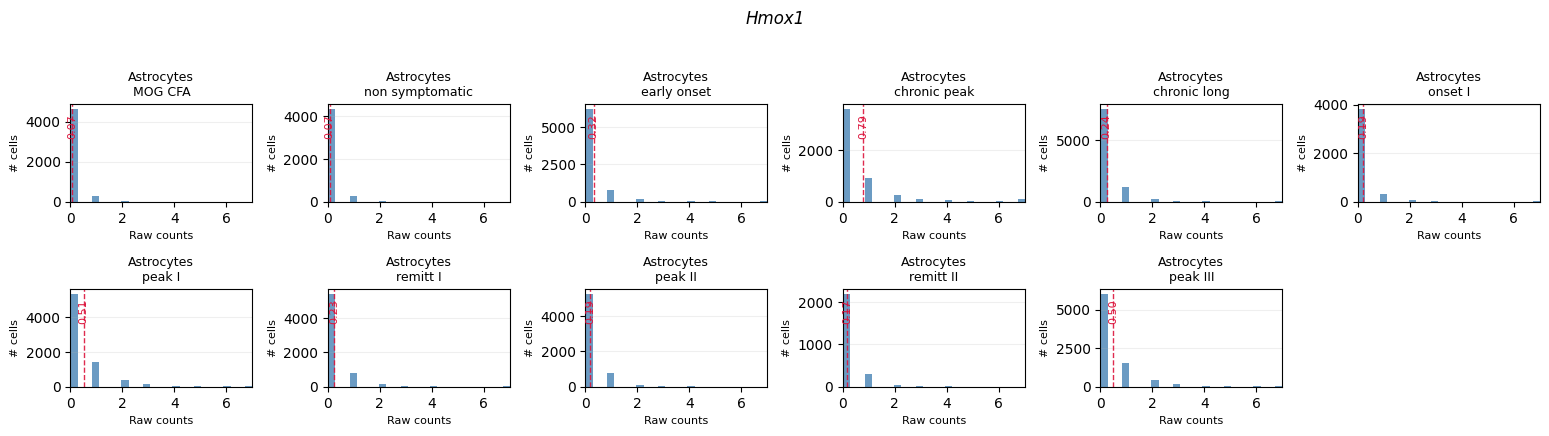

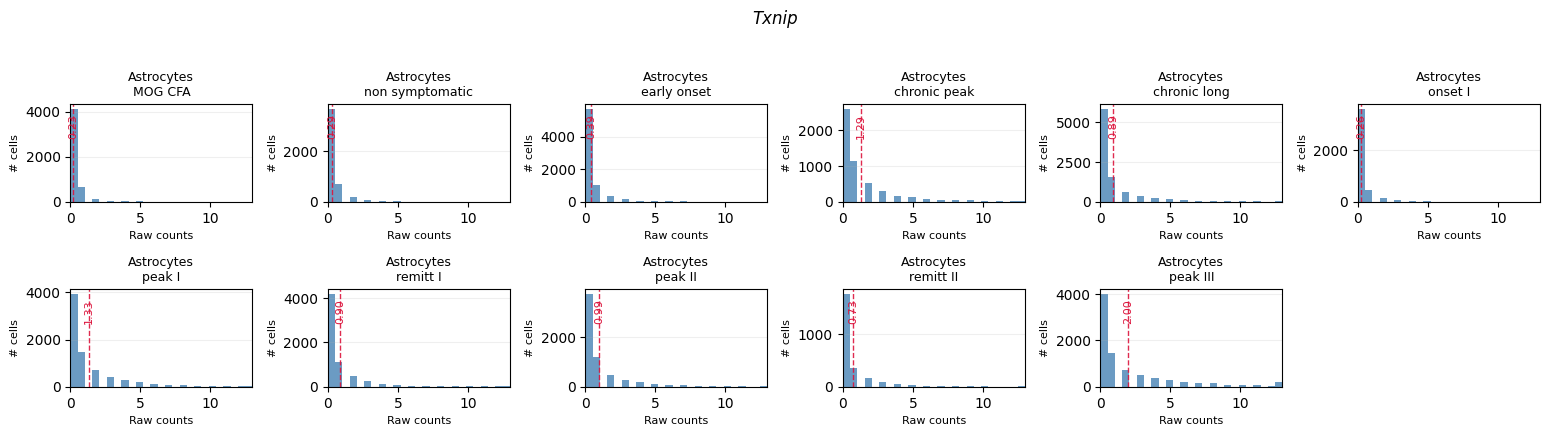

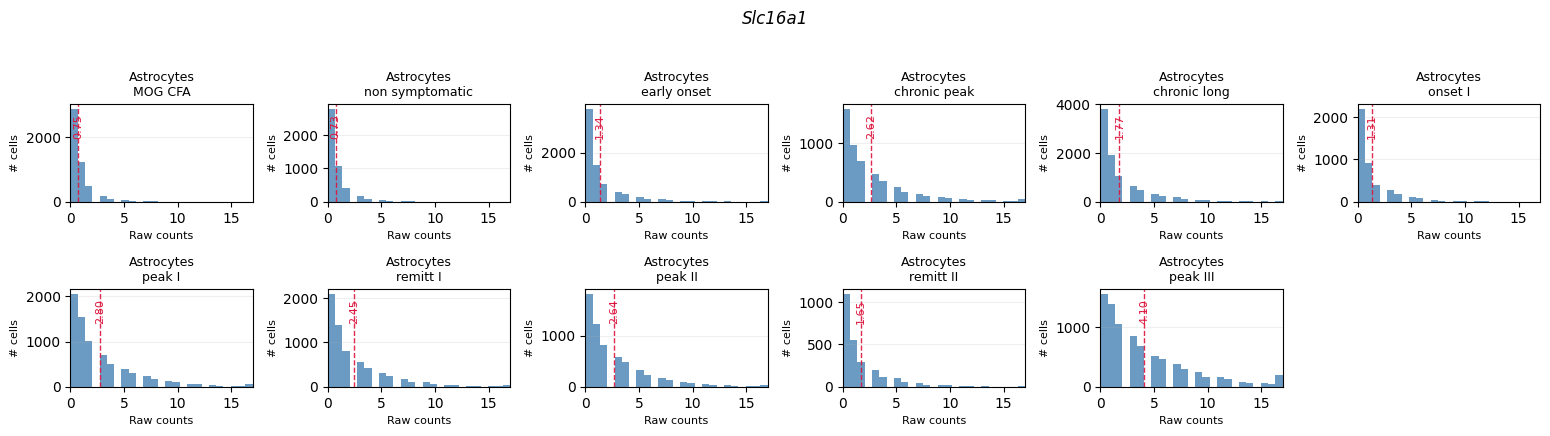

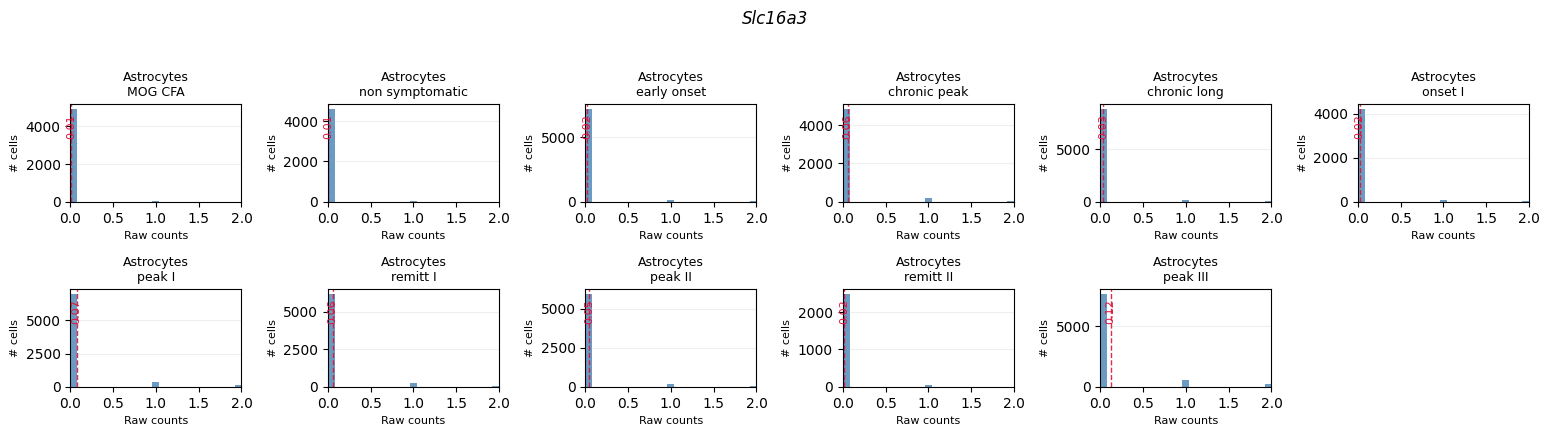

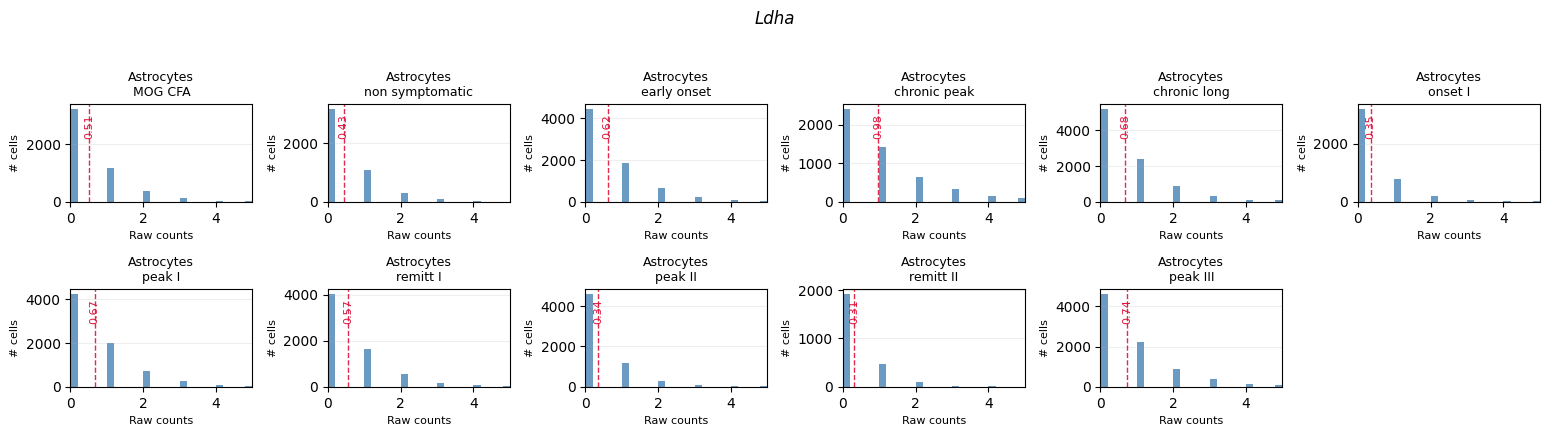

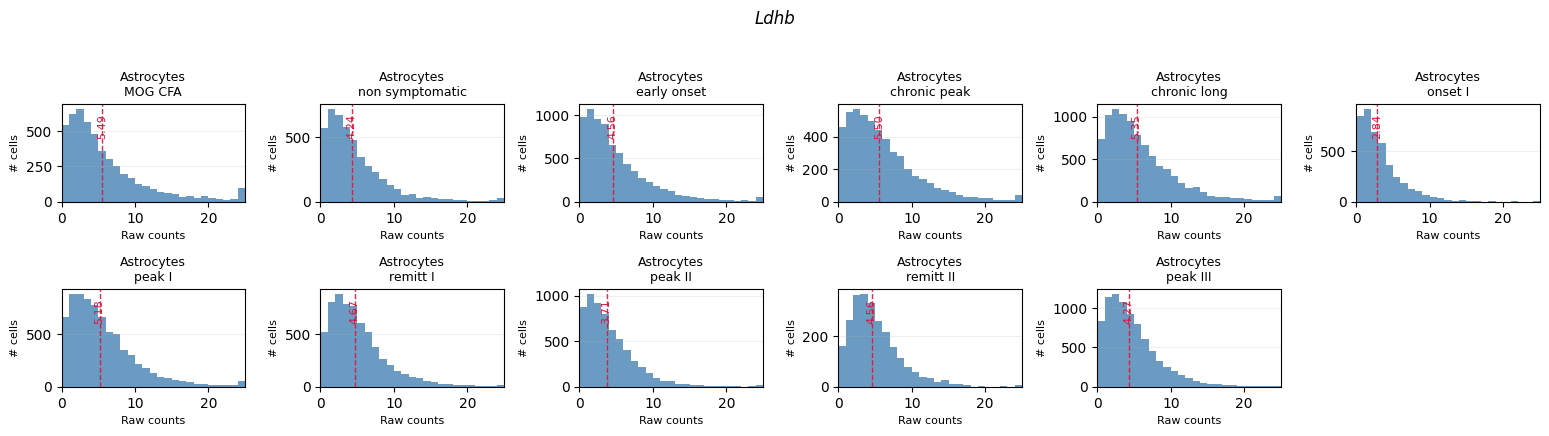

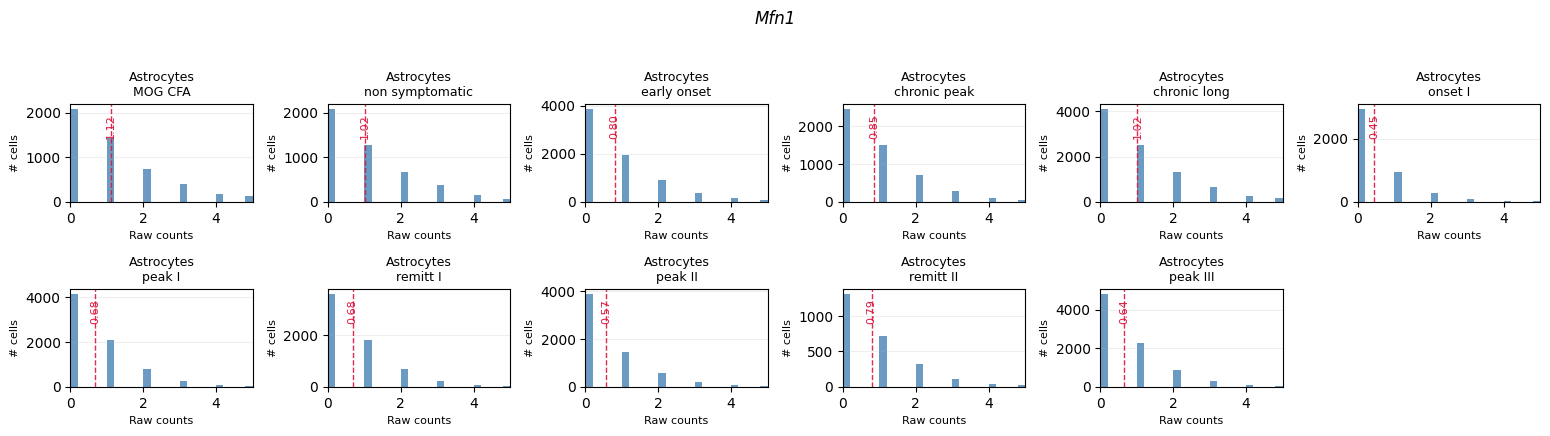

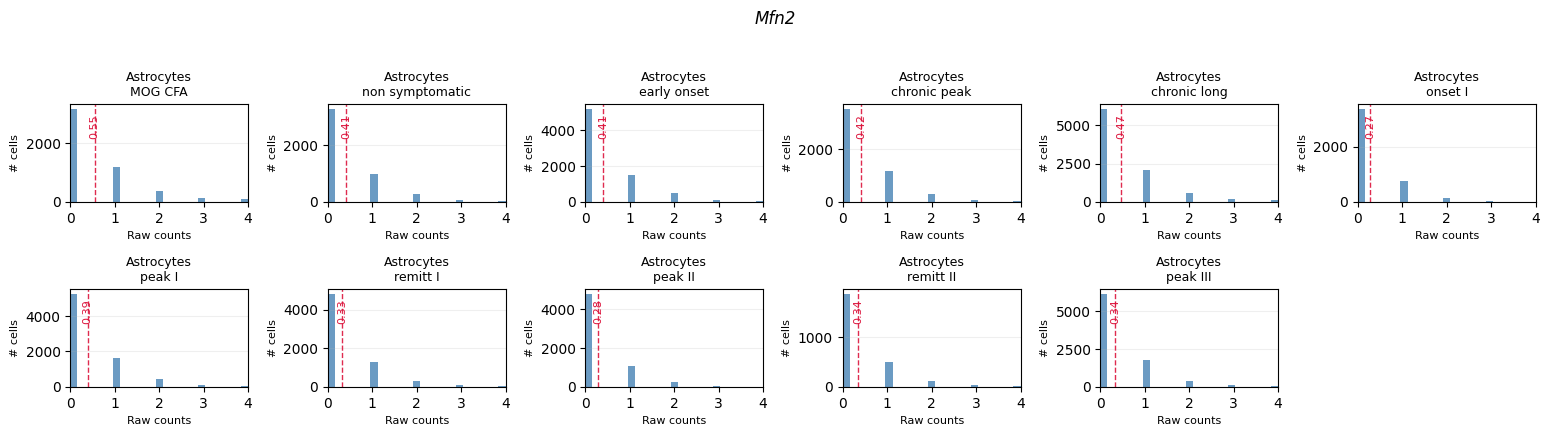

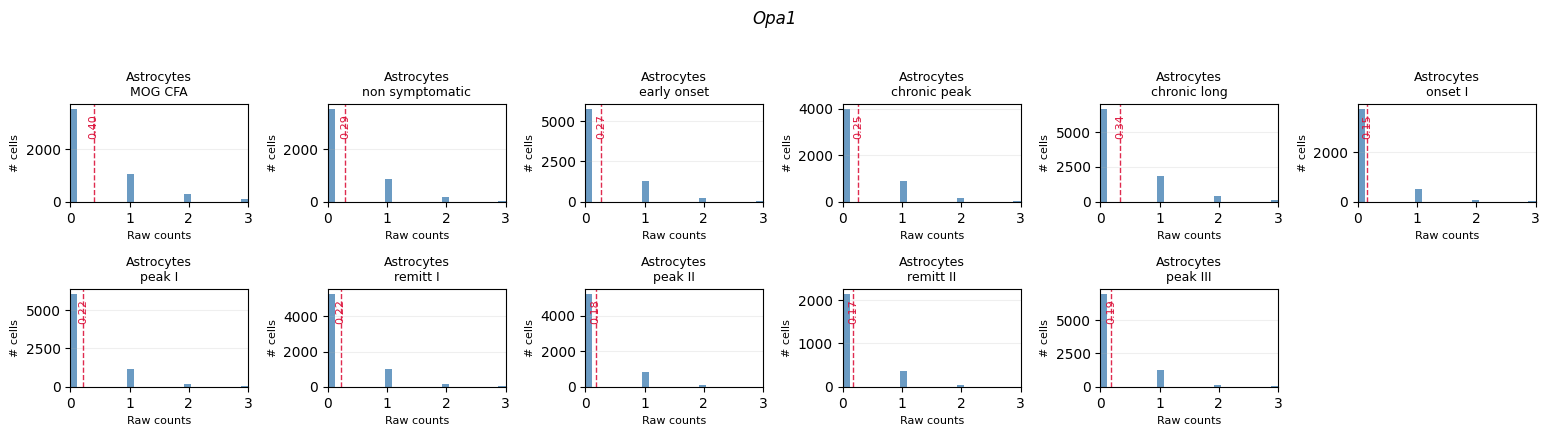

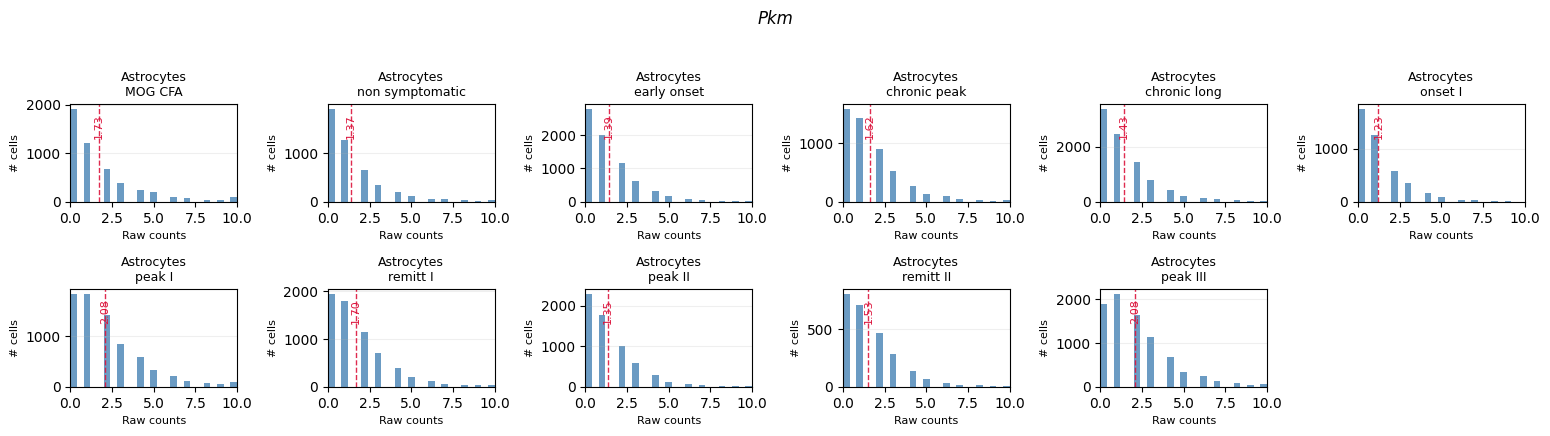

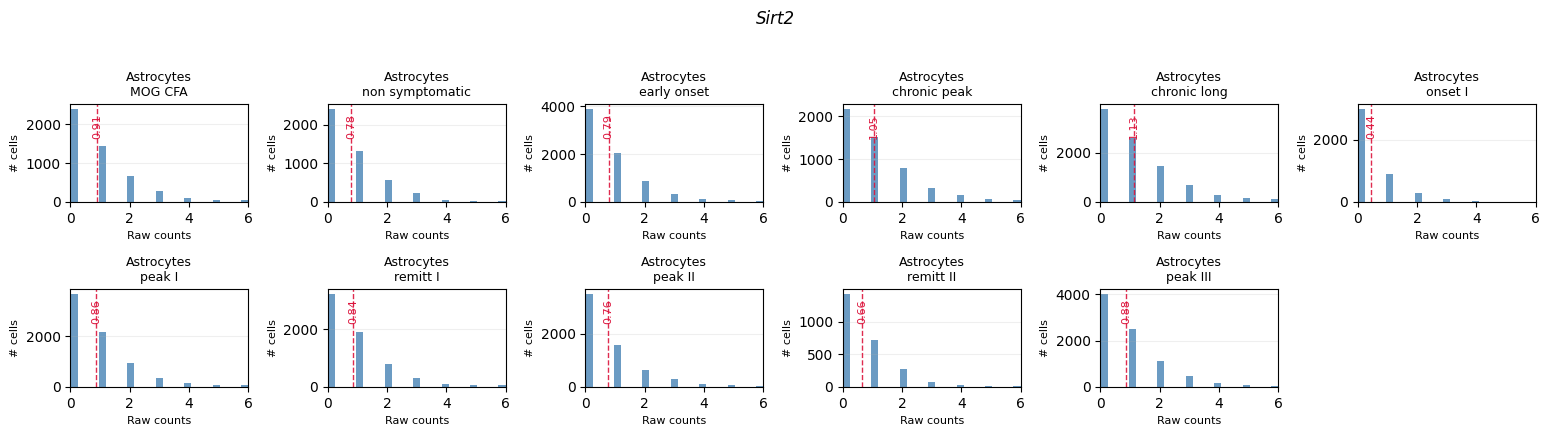

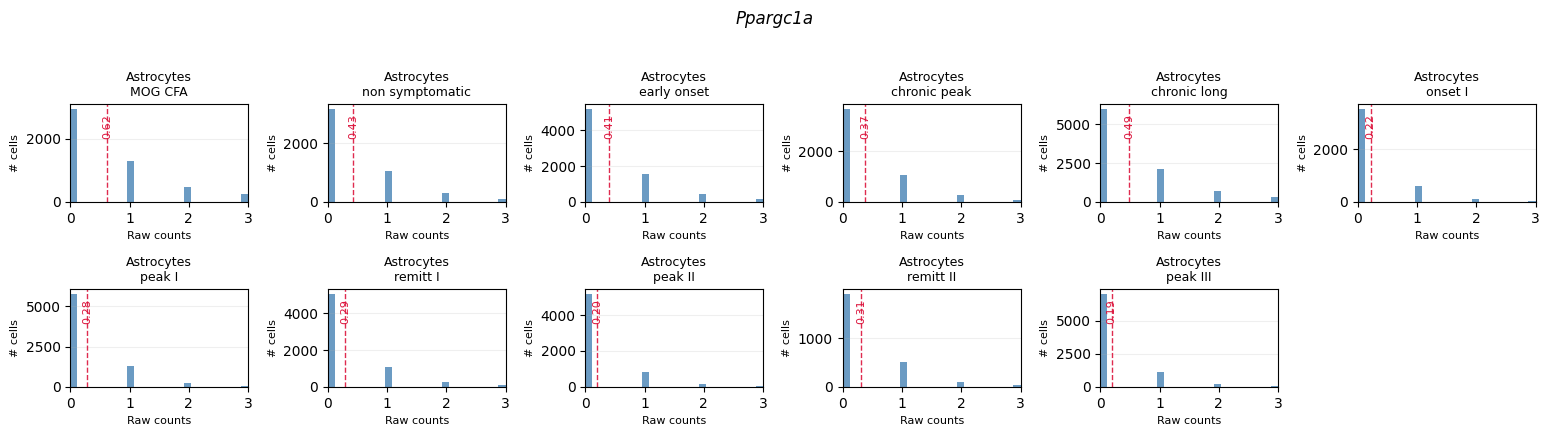

In [11]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]

histograms_separate_per_group(
    adata, genes,
    celltypes=["Astrocytes"],         # pick what you want
    courses=['MOG CFA',"non symptomatic","early onset","chronic peak","chronic long",
             "onset I","peak I","remitt I","peak II","remitt II","peak III"],
    condition=None,#"EAE",   # or "CONTROL"
    bins=25, q=0.995, max_cells_per_group=10000
)

In [12]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

MODEL_LABEL_TO_FAMILY = {"Chronic": "MOG", "RR": "PLP"}  # adjust if different

def compute_pct_expressing(
    adata,
    genes,
    celltype_col="cell_type_reduced",
    course_col="course",
    model_col="model",
    condition_col="condition",
    use_condition="EAE",          # % is usually computed within the case samples
    layer="raw",
):
    X = adata.layers[layer] if layer in adata.layers else adata.X
    if sp.issparse(X): X = X.tocsr()
    var_idx = {g:i for i,g in enumerate(adata.var_names)}
    gene_cols = [var_idx[g] for g in genes if g in var_idx]

    obs = adata.obs.copy()
    obs["_celltype"] = obs[celltype_col].astype(str).str.strip()
    obs["_course"]   = obs[course_col].astype(str).str.strip()
    obs["_model"]    = obs[model_col].astype(str).str.strip() if model_col in obs.columns else "All"
    obs["_cond"]     = obs[condition_col].astype(str).str.strip().str.upper() if condition_col in obs.columns else None

    # filter to EAE (or desired condition) for % expressing
    if condition_col in adata.obs.columns and use_condition is not None:
        keep = obs["_cond"] == use_condition.upper()
        obs = obs.loc[keep]
        X = X[keep.values, :]

    # groups: (celltype, model-label -> "Chronic model"/"Relapse-remitting model", course)
    obs["_model_label"] = obs["_model"].map(lambda s: "Chronic model" if s=="Chronic" else ("Relapse-remitting model" if s=="RR" else s))

    groups = obs.groupby(["_celltype","_model_label","_course"]).indices  # dict -> index array
    records = []
    for (ct, mdl, crs), idx in groups.items():
        sub = X[idx, :][:, gene_cols]
        A = sub.toarray() if sp.issparse(sub) else np.asarray(sub)
        # % expressing (>0)
        pct = (A > 0).mean(axis=0) * 100.0
        for g, p in zip([g for g in genes if g in var_idx], pct):
            records.append({"celltype": ct, "model": mdl, "course": crs, "gene": g, "pct_expr": p})
    return pd.DataFrame.from_records(records)

In [66]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import numpy as np

def plot_dotpanels(log2fc_df, pct_df, genes, MODELS,
                   celltypes=("Astrocytes","Oligodendrocytes"),
                   model_order=("Chronic model","Relapse-remitting model"),
                   vmax=2.0, cmap="RdBu_r", size_scale=6.0):

    # ----- layout: 6 columns = [A_chronic, A_RR, spacer, O_chronic, O_RR, cbar]
    fig = plt.figure(figsize=(14, 5))
    gs  = GridSpec(nrows=1, ncols=6, figure=fig,
                   width_ratios=[1,1,0.15, 1,1, 0.08], wspace=0.35)

    axes = [
        fig.add_subplot(gs[0, 0]),  # Astro chronic
        fig.add_subplot(gs[0, 1]),  # Astro RR
        None,                       # spacer (empty)
        fig.add_subplot(gs[0, 3]),  # Oligo chronic
        fig.add_subplot(gs[0, 4])   # Oligo RR
    ]
    cax = fig.add_subplot(gs[0, 5])

    norm = TwoSlopeNorm(vcenter=0.0, vmax=vmax)
    cmap_obj = plt.get_cmap(cmap)

    def course_order_for(model_label):
        fam = "MOG" if "Chronic" in model_label else "PLP"
        return MODELS[fam]["courses"]

    # panel order aligned with axes above
    panels = [(celltypes[0], model_order[0]),
              (celltypes[0], model_order[1]),
              None,
              (celltypes[1], model_order[0]),
              (celltypes[1], model_order[1])]

    last_sc = None
    for ax, spec in zip(axes, panels):
        if spec is None:  # spacer
            continue
        ct, mdl = spec
        d_color = log2fc_df.query("celltype == @ct and model == @mdl")
        d_size  = pct_df   .query("celltype == @ct and model == @mdl")
        d = d_color.merge(d_size, on=["celltype","model","course","gene"], how="inner")
        if d.empty:
            ax.axis("off"); continue

        stages = course_order_for(mdl)
        xmap = {c:i for i,c in enumerate(stages)}
        ymap = {g:i for i,g in enumerate(genes)}
        d = d[d["gene"].isin(genes) & d["course"].isin(stages)].copy()
        d["x"] = d["course"].map(xmap)
        d["y"] = d["gene"].map(ymap)
        sizes = (np.clip(d["pct_expr"].values, 0, 100)/100.0) * (size_scale**2) * 100

        last_sc = ax.scatter(d["x"], d["y"], c=d["log2fc"], s=sizes,
                             cmap=cmap_obj, norm=norm, edgecolors="k", linewidths=0.3)

        ax.set_xticks(range(len(stages))); ax.set_xticklabels(stages, rotation=90, fontsize=9)
        ax.set_yticks(range(len(genes)));  ax.set_yticklabels(genes, fontsize=10, fontstyle="italic")
        ax.set_xlim(-0.5, len(stages)-0.5); ax.set_ylim(-0.5, len(genes)-0.5)
        ax.grid(True, axis="x", alpha=0.2)
        ax.set_title(mdl, fontsize=12, fontweight="semibold")
        # --- NEW: hide gene labels for relapse-remitting model ---
        if "Relapse-remitting" in mdl:
            ax.set_yticklabels([])
            ax.set_yticks([])
    import matplotlib.patches as mpatches

    # after plotting all the scatter plots and before plt.show()
    if last_sc is not None:
        # colorbar
        cbar = fig.colorbar(last_sc, cax=cax)
        cbar.set_label("log2FC vs CONTROL baseline", rotation=90)
    
        # --- add size legend for % expressing ---
        # choose a few reference percentages
        ref_pcts = [10, 50, 100]
        handles = []
        for p in ref_pcts:
            size = (p/100.0) * (size_scale**2) * 100
            handles.append(
                plt.scatter([], [], s=size, facecolors="none",
                            edgecolors="k", linewidths=0.5,
                            label=f"{p}%")
            )
        # place legend to the right under the colorbar
        fig.legend(handles=handles, title="% cells expressing",
                   loc="center left", bbox_to_anchor=(0.97, 0.25),
                   frameon=False)
    # ---- centered headers exactly above each pair ----
    # Astro pair: axes[0], axes[1]
    for pair_axes, label in [(axes[0:2], celltypes[0]), (axes[3:5], celltypes[1])]:
        left, right = pair_axes[0].get_position(), pair_axes[1].get_position()
        mid_x = (left.x0 + right.x1) / 2.0
        y_top = left.y1 + 0.06
        fig.text(mid_x, y_top, label, ha="center", va="bottom",
                 fontsize=16, fontweight="bold")

    # ---- colorbar moved further right, aligned to all panels ----
    if last_sc is not None:
        cbar = fig.colorbar(last_sc, cax=cax)
        cbar.set_label("log2FC vs CONTROL baseline", rotation=90)

    # tighten a bit
    plt.subplots_adjust(left=0.1, right=0.85, bottom=0.15, top=0.88)
    plt.show()

In [67]:
np.array(genes).transpose()

array(['Ppargc1a', 'Sirt2', 'Pkm', 'Opa1', 'Mfn2', 'Mfn1', 'Ldhb', 'Ldha',
       'Slc16a3', 'Slc16a1', 'Txnip', 'Hmox1', 'Pik3cd', 'Akt1', 'Nfe2l2',
       'Hif1a'], dtype='<U8')

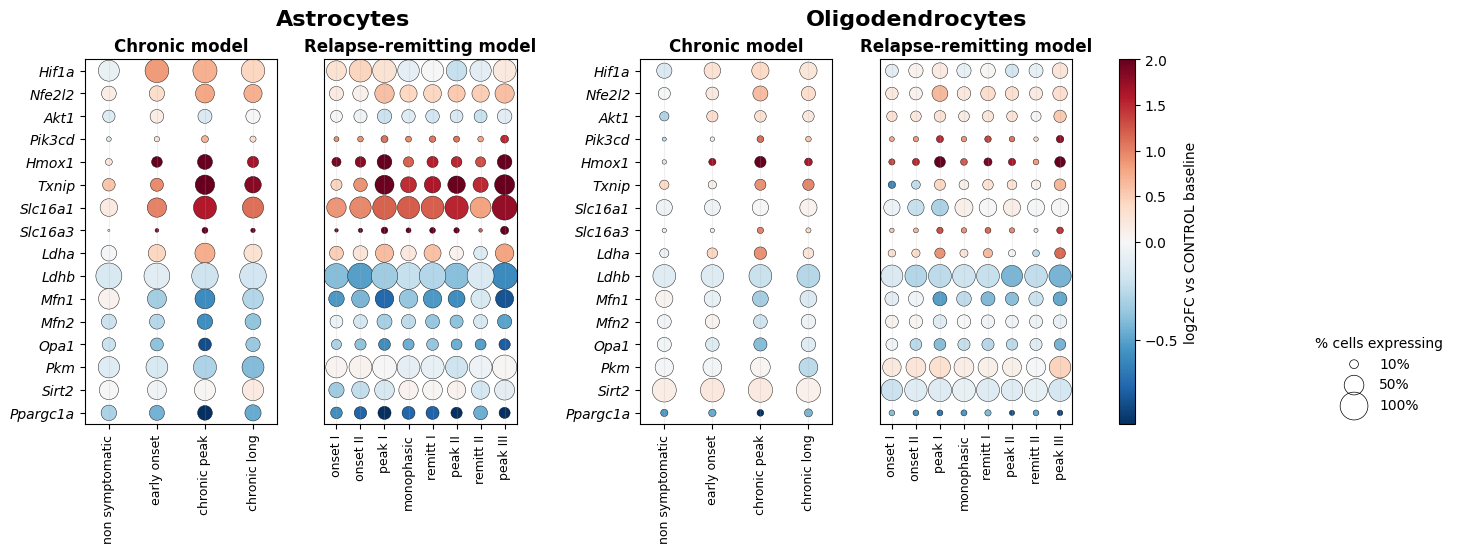

In [70]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]
genes = genes[::-1]

# 1) % expressing within EAE cells
pct_df = compute_pct_expressing(
    adata, genes,
    celltype_col="cell_type_reduced",
    course_col="course",
    model_col="model",
    condition_col="condition",
    use_condition="EAE",
    layer="raw"
)

# 2) Dot plot (size = %, color = your log2FC table)
plot_dotpanels(
    log2fc_df, pct_df, genes,MODELS,
    celltypes=("Astrocytes","Oligodendrocytes"),   # or add "Microglia", "OPCs", etc.
   vmax=2, size_scale=2
)

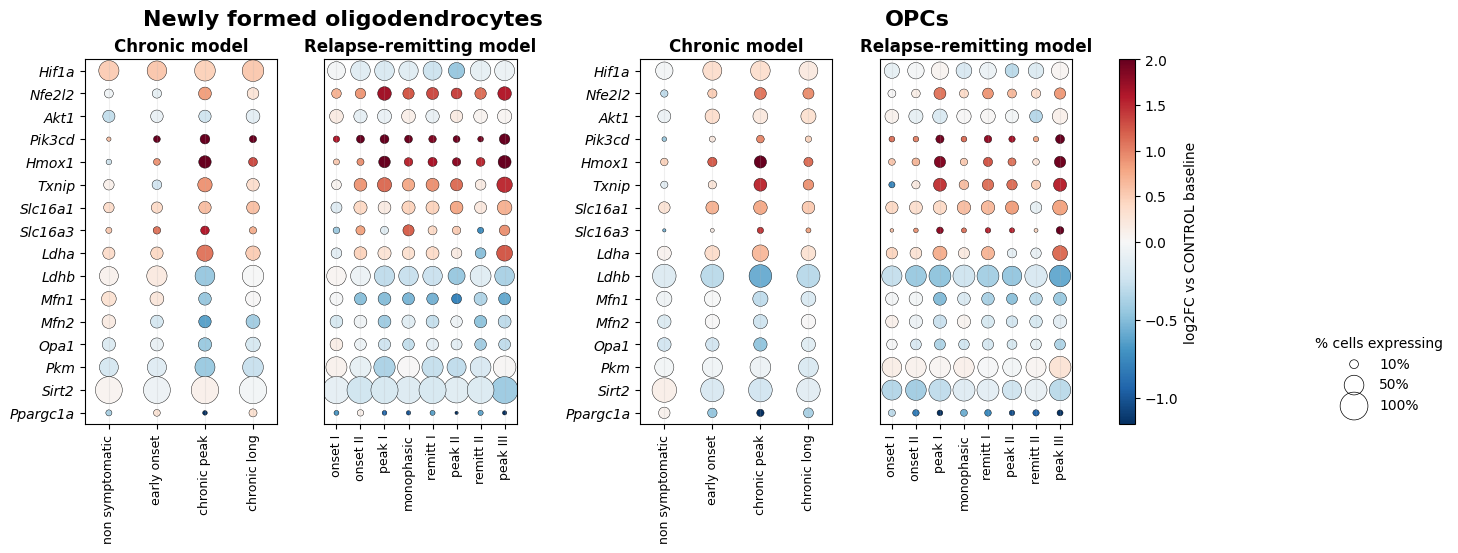

In [71]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]
genes = genes[::-1]

# 1) % expressing within EAE cells
pct_df = compute_pct_expressing(
    adata, genes,
    celltype_col="cell_type_reduced",
    course_col="course",
    model_col="model",
    condition_col="condition",
    use_condition="EAE",
    layer="raw"
)

# 2) Dot plot (size = %, color = your log2FC table)
plot_dotpanels(
    log2fc_df, pct_df, genes,MODELS,
    celltypes=("Newly formed oligodendrocytes","OPCs"),   # or add "Microglia", "OPCs", etc.
   vmax=2, size_scale=2
)

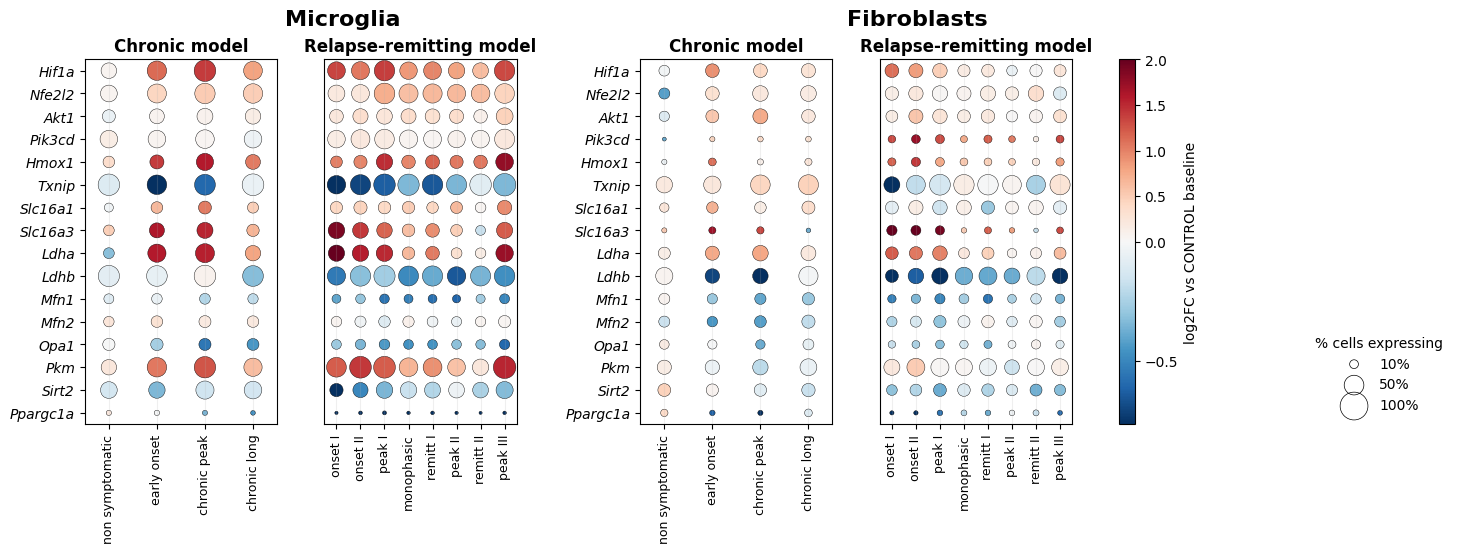

In [72]:
genes = ["Hif1a","Nfe2l2","Akt1","Pik3cd","Hmox1","Txnip","Slc16a1","Slc16a3",
         "Ldha","Ldhb","Mfn1","Mfn2","Opa1","Pkm","Sirt2","Ppargc1a"]
genes = genes[::-1]

# 1) % expressing within EAE cells
pct_df = compute_pct_expressing(
    adata, genes,
    celltype_col="cell_type_reduced",
    course_col="course",
    model_col="model",
    condition_col="condition",
    use_condition="EAE",
    layer="raw"
)

# 2) Dot plot (size = %, color = your log2FC table)xthe N
plot_dotpanels(
    log2fc_df, pct_df, genes,MODELS,
    celltypes=("Microglia","Fibroblasts"),   # or add "Microglia", "OPCs", etc.
   vmax=2, size_scale=2
)